In [1]:
import os
os.chdir("../")

In [2]:
%pwd

'd:\\Advanced Project\\Lesion-Stroke-Segmentation'

In [4]:
from dataclasses import dataclass
from pathlib import Path

In [5]:
@dataclass(frozen=True)
class PredictionEntity:
    model: Path

In [6]:
from lesionSeg.constant import *
from lesionSeg.Utils.common import read_yaml, create_directory

In [21]:
class ConfigurationManagers:
    def __init__(self, params=PARAMS_FILE_PATH, config=CONFIG_FILE_PATH):
        self.params = read_yaml(params)
        self.config = read_yaml(config)

        create_directory([self.config.artifact_root])

    def prediction_config(self):
        config = self.config.prediction

        pred_config = PredictionEntity(
            model=config.base_model
        )

        return pred_config

In [ ]:
from lesionSeg.Component.data_preprocessing import DataPreprocessing
from lesionSeg.models.loss import focal_tversky_loss
from lesionSeg.models.metrices import dice_coff
from lesionSeg.Config.configuration import ConfigurationManager
import numpy as np
from scipy import ndimage
import tensorflow as tf
import cv2

In [43]:
class Prediction:
    def __init__(self, config: PredictionEntity):
        self.config = config
        config_man = ConfigurationManager()
        preprocess_config = config_man.data_preprocessing_config()

        self.pre_process_config = DataPreprocessing(config=preprocess_config)

    def img_preprocess(self, image):
        # resize the image
        if image.ndim < 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        height_factor, width_factor = self.pre_process_config.calculate_resize_factors(image)
        resized_image = ndimage.zoom(image, (width_factor, height_factor, 1), order=1)
        img = np.expand_dims(resized_image, axis=0)

        return img

    def model_prediction(self, image):
        # load model
        model_dir = self.config.model
        model = tf.keras.models.load_model(model_dir, 
                                           custom_objects={
                        'focal_tversky_loss': focal_tversky_loss,
                        'dice_coff': dice_coff,
                        'iou':tf.keras.metrics.IoU,
                        'precision':tf.keras.metrics.Precision,
                        'recall':tf.keras.metrics.Recall
                    })
        pre_process_img = self.img_preprocess(image=image)
        pred = model.predict(pre_process_img)
        pred_mask = (pred > 0.5).astype(np.uint8)

        return pred_mask[0]

In [53]:
img_name = "r001s002_60.png"
root_dir = "artifact\data_preprocessed\Training\input"
img = cv2.imread(os.path.join(root_dir, img_name))

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\ehtes\AppData\Local\Temp\ipykernel_3076\2518530974.py:2: SyntaxWarning: invalid escape sequence '\d'
  root_dir = "artifact\data_preprocessed\Training\input"


In [54]:
img.shape

(128, 128, 3)

In [55]:
try:
    config = ConfigurationManagers()
    pred_config = config.prediction_config()
    prediction = Prediction(config = pred_config)
    result = prediction.model_prediction(img)
except Exception as e:
    raise e

[2025-02-23 23:07:12,193]: INFO: common : Read YAML File: params.yaml
[2025-02-23 23:07:12,199]: INFO: common : Read YAML File: config\config.yaml
[2025-02-23 23:07:12,201]: INFO: common : Directory has been Created: artifact
[2025-02-23 23:07:12,203]: INFO: common : Read YAML File: params.yaml
[2025-02-23 23:07:12,206]: INFO: common : Read YAML File: config\config.yaml
[2025-02-23 23:07:12,210]: INFO: common : Directory has been Created: artifact
[2025-02-23 23:07:12,212]: INFO: common : Directory has been Created: artifact\data_preprocessed
[2025-02-23 23:07:12,213]: INFO: common : Directory has been Created: artifact\data_preprocessed\Training\input
[2025-02-23 23:07:12,215]: INFO: common : Directory has been Created: artifact\data_preprocessed\Training\output
[2025-02-23 23:07:12,215]: INFO: common : Directory has been Created: artifact\data_preprocessed\Testing\input
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


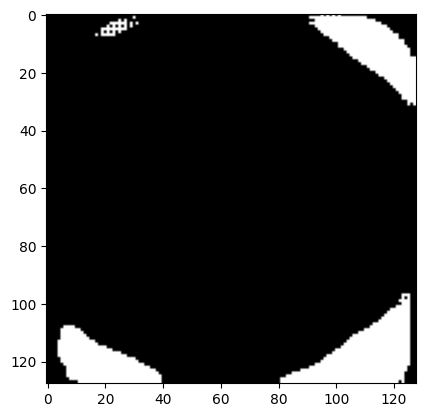

In [56]:
import matplotlib.pyplot as plt

plt.imshow(result, cmap='grey')